# 02_Preprocessing_and_Modeling

In this notebook we will build our preprocessing pipelines to handle:
1. Missing‐value imputation  
2. Categorical variable encoding  
3. Feature scaling 

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline as Pl
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as ImbPl
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from pathlib import Path

# Global (metrics)
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



## 0. Feature Engineering

In [26]:
# Load raw CSV (semicolon-delimited) & tidy headers
df = pd.read_csv(Path('../data/data0.csv'), sep=';')
df.columns = df.columns.str.strip()

### Raw Data Loading & Initial Cleaning

1. **Cast Categorical Codes**  
   Convert all integer-coded label columns (e.g. marital status, application mode, parental qualifications, etc.) into pandas `category` dtype for efficient storage and downstream encoding.

2. **Drop Redundant Feature**  
   Remove the `Daytime/evening attendance` column, as it is no longer needed for our analysis.

3. **Prune Semester Features**  
   From all the “Curricular units” columns, keep only the four key semester metrics (grades and approval flags for 1st and 2nd semester) and drop the rest.

After this step, the dataset is tidied and reduced to the core variables we’ll use for feature engineering and modeling.

In [27]:

# 1 ── Cast int-coded label columns to category
code_cols = [
    'Marital status','Application mode','Application order','Course',
    'Daytime/evening attendance','Previous qualification','Nacionality',
    "Mother's qualification","Father's qualification",
    'Displaced','Educational special needs','Debtor',
    'Tuition fees up to date','Gender','Scholarship holder',
    "Mother's occupation","Father's occupation",
    'International'
]
df[code_cols] = df[code_cols].astype('category')

# 2 ── Drop redundant feature
df = df.drop(columns='Daytime/evening attendance')

# 3 ── Keep only the four key semester features
keep_sem = [
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (approved)'
]
sem_cols = [c for c in df.columns if 'Curricular units' in c and c not in keep_sem]
df = df.drop(columns=sem_cols)

print('Cleaned shape:', df.shape)


Cleaned shape: (4424, 28)


### Encode Target and Stratified Split (70/15/15)

1. **Encode the target**  
   We convert the `Target` column into numeric labels (`0, 1, ...`) using `LabelEncoder` so that our classifiers can work with it.

2. **Create stratified splits**  
   To preserve the class distribution in each subset, we perform a two‐stage stratified split:
   - **Test set (15%)**: Held out for the *final* evaluation of our models.
   - **Validation set (15% of the remaining 85%, i.e. ~12.75% of the total)**: Used for hyperparameter tuning and early stopping.
   - **Training set (remaining 70%)**: Used to fit our preprocessing pipelines and train the models.

3. **Reproducibility**  
   We set `random_state=42` in both splits to ensure that results can be reproduced.

In [28]:
# 5 ── Encode target and stratify 70/15/15
le = LabelEncoder()
y = le.fit_transform(df['Target'])
X = df.drop(columns='Target')

all_features = X.columns.tolist()

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

Train: (3096, 27) Val: (664, 27) Test: (664, 27)


We replicate the casting and feature-pruning decisions from notebook 01 so that all subsequent preprocessing steps operate on the same cleaned dataset.

## 1. Resulting columns

- **Numeric features** (floats)  
- **Categorical features** (integer‐coded categories)

In [29]:
cat_cols = df.select_dtypes('category').columns.tolist()         
num_cols = df.select_dtypes(['int64', 'float64']).columns.tolist()  

for lst in (cat_cols, num_cols):
    if 'Target' in lst:
        lst.remove('Target')

print("Categorical features:", cat_cols)
print("Numeric features:", num_cols)

Categorical features: ['Marital status', 'Application mode', 'Application order', 'Course', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']
Numeric features: ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Unemployment rate', 'Inflation rate', 'GDP']


In [30]:
ord_cols = [
    'Previous qualification',
    "Mother's qualification",
    "Father's qualification",
    'Application order'
]

nom_cols = [c for c in cat_cols if c not in ord_cols]

print("Ordinal features :", ord_cols)
print("Nominal features :", nom_cols)


Ordinal features : ['Previous qualification', "Mother's qualification", "Father's qualification", 'Application order']
Nominal features : ['Marital status', 'Application mode', 'Course', 'Nacionality', "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']


## 2. Build preprocessing pipelines

- **Numeric pipeline**: impute (median) → scale (StandardScaler)  
- **Categorical pipeline**: (optional) impute constant → encode (OneHotEncoder)

In [31]:
# 0 │ Ensure ordinal columns are strings in all splits

for df_part in (X_train, X_val, X_test):
    df_part[ord_cols] = df_part[ord_cols].astype(str)


# 1 │ Custom orders (as **strings**)

qual_order = [34, 35, 36, 37, 38, 11, 26, 30, 29, 19, 14, 10, 12,  9,  1,
              27, 13, 25, 20, 18, 22, 31, 33, 39,  2, 40,  3, 41, 42, 43,
               4, 44,  5,  6]                       # Unknown (34) first
qual_order_str = list(map(str, qual_order))
app_order_str  = list(map(str, range(0, 10)))       # 0 = 1st choice … 9 = 10th

ord_enc = OrdinalEncoder(
    categories=[qual_order_str,           # Previous qualification
                qual_order_str,           # Mother's qualification
                qual_order_str,           # Father's qualification
                app_order_str],           # Application order
    dtype='int8',
    handle_unknown='use_encoded_value',
    unknown_value=-1
)


# 2 │ Pipelines

num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

ord_pipe = Pipeline([
    ('encoder', ord_enc)
])

nom_pipe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore',
                             sparse_output=False))   # scikit-learn ≥ 1.4
])


# 3 │ ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('ord', ord_pipe, ord_cols),
        ('nom', nom_pipe, nom_cols)
    ],
    remainder='drop'        # every predictor is assigned
)


# 4 │ Fit-transform

X_train_preprocessed = preprocessor.fit_transform(X_train)
print("Preprocessed X_train shape:", X_train_preprocessed.shape)


Preprocessed X_train shape: (3096, 160)


In [32]:
def time_model(estimator, X, y, cv=cv5):
    """
    Returns mean training time and mean scoring (inference) time
    over the supplied CV splitter.
    """
    cv_res = cross_validate(
        estimator, X, y,
        cv=cv,
        scoring='f1_macro',          # same metric you used in GridSearchCV
        n_jobs=-1,
        return_train_score=False     # we only need fit_time & score_time
    )
    return cv_res['fit_time'].mean(), cv_res['score_time'].mean()


## 3.1 Full pipeline & hyperparameter tuning -> Random Forest

In [44]:

selector = VarianceThreshold(threshold=0.01)

# Build the full pipeline
rf_pipe = Pl([('preproc', preprocessor), 
              ('select',  selector), 
              ('clf', RandomForestClassifier(random_state=42))])

rf_param_grid = {
    'select__threshold':    [0.0, 0.005, 0.01],  # no selection vs. two levels
    'clf__n_estimators':    [100, 200],          # number of trees
    'clf__max_depth':       [None, 10, 20],      # tree depth
    'clf__class_weight':    [None, 'balanced']   # handle class imbalance
}

rf_search = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True,    refit=True,
    error_score='raise'
)

rf_search.fit(X_train, y_train)

print("Best parameters:", rf_search.best_params_)
print("Best CV f1_macro:", rf_search.best_score_)

rf_pred = rf_search.best_estimator_.predict(X_test)
rf_f1   = f1_score(y_test, rf_pred, average='macro')

print(f"RF   Test F1-macro: {rf_f1:.3f}")

rf_acc  = accuracy_score(y_test, rf_search.best_estimator_.predict(X_test))
print(f"RF   Test accuracy: {rf_acc:.3f}")

rf_fit_t, rf_pred_t = time_model(
    rf_search.best_estimator_, X_train, y_train
)
print(f"Random Forest mean train time:   {rf_fit_t:.3f} s")
print(f"Random Forest mean predict time: {rf_pred_t:.3f} s")

Best parameters: {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__n_estimators': 200, 'select__threshold': 0.0}
Best CV f1_macro: 0.6984885789168798
RF   Test F1-macro: 0.702
RF   Test accuracy: 0.748
Random Forest mean train time:   0.972 s
Random Forest mean predict time: 0.047 s


              precision    recall  f1-score   support

     Dropout       0.82      0.69      0.75       213
    Enrolled       0.45      0.58      0.51       119
    Graduate       0.85      0.84      0.84       332

    accuracy                           0.75       664
   macro avg       0.71      0.71      0.70       664
weighted avg       0.77      0.75      0.75       664



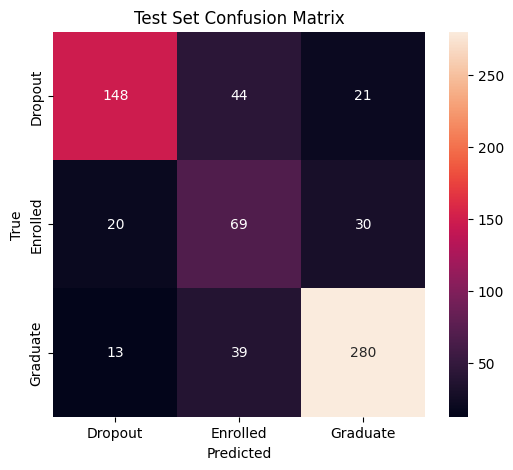

In [34]:

# Retrieve best model
best_model = rf_search.best_estimator_

# Predict on test
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()

## 3.2 Full pipeline & hyperparameter tuning -> Decision Tree

In [45]:
dt_pipe = Pl([('preproc', preprocessor), ('select',  selector), ('clf', DecisionTreeClassifier(random_state=42))])

dt_param_grid = {
    'select__threshold':    [0.0, 0.005, 0.01],      # same selector choices
    'clf__max_depth':       [None, 5, 10, 20],       # tree depth
    'clf__min_samples_split': [2, 5, 10],            # controls overfitting
    'clf__class_weight':    [None, 'balanced']       # handle class imbalance
}

dt_search = GridSearchCV(
    dt_pipe,
    dt_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    error_score='raise'
)
dt_search.fit(X_train, y_train)

print("Decision Tree best params:", dt_search.best_params_)
print("Decision Tree best CV f1_macro:", dt_search.best_score_)

dt_pred = dt_search.best_estimator_.predict(X_test)
dt_f1   = f1_score(y_test, dt_pred, average='macro')

print(f"DT   Test F1-macro: {dt_f1:.3f}")

dt_acc  = accuracy_score(y_test, dt_search.best_estimator_.predict(X_test))
print(f"DT   Test accuracy: {dt_acc:.3f}")

# Measure mean train & predict times via the helper
dt_fit_t, dt_pred_t = time_model(
    dt_search.best_estimator_, X_train, y_train
)
print(f"Decision Tree mean train time:   {dt_fit_t:.3f} s")
print(f"Decision Tree mean predict time: {dt_pred_t:.3f} s")

Decision Tree best params: {'clf__class_weight': 'balanced', 'clf__max_depth': 5, 'clf__min_samples_split': 2, 'select__threshold': 0.005}
Decision Tree best CV f1_macro: 0.6632784005108501
DT   Test F1-macro: 0.681
DT   Test accuracy: 0.715
Decision Tree mean train time:   0.070 s
Decision Tree mean predict time: 0.021 s


              precision    recall  f1-score   support

     Dropout       0.85      0.66      0.74       213
    Enrolled       0.41      0.64      0.50       119
    Graduate       0.83      0.78      0.80       332

    accuracy                           0.72       664
   macro avg       0.69      0.69      0.68       664
weighted avg       0.76      0.72      0.73       664



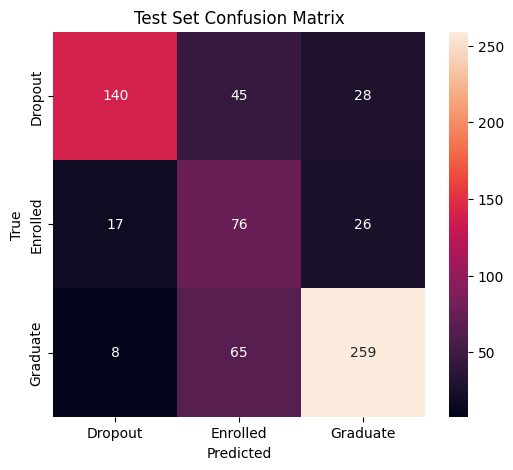

In [36]:
# Retrieve best model
best_model = dt_search.best_estimator_

# Predict on test
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()

## 3.3 Full pipeline & hyperparameter tuning -> K-Nearest Neighbors

In [46]:
cat_idx = [all_features.index(c) for c in cat_cols]

smote_nc = SMOTENC(
    categorical_features=cat_idx,
    sampling_strategy='auto',
    k_neighbors=3,
    random_state=42
)


knn_pipe = ImbPl([
    ('preproc', preprocessor),         
    ('smote',   smote_nc), 
    ('select', VarianceThreshold()),   
    ('clf', KNeighborsClassifier()) 
])

knn_param_grid = {
    'select__threshold': [0.0, 0.005, 0.01],  # selector choices
    'clf__n_neighbors': [3, 5, 7, 9],         # how many neighbors
    'clf__weights': ['uniform', 'distance'],  # weighting of votes
    'clf__p': [1, 2]                          # L1 (Manhattan) vs. L2 (Euclidean)
}

knn_search = GridSearchCV(
    knn_pipe,
    knn_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    error_score='raise'
)
knn_search.fit(X_train, y_train)

print("KNN best params:", knn_search.best_params_)
print("KNN best CV f1_macro:", knn_search.best_score_)

knn_pred = knn_search.best_estimator_.predict(X_test)
knn_f1   = f1_score(y_test, knn_pred, average='macro')

print(f"k-NN Test F1-macro: {knn_f1:.3f}")

knn_acc = accuracy_score(y_test, knn_search.best_estimator_.predict(X_test))
print(f"k-NN Test accuracy: {knn_acc:.3f}")

knn_fit_t, knn_pred_t = time_model(
    knn_search.best_estimator_, X_train, y_train
)
print(f"k-NN + SMOTENC mean train time:   {knn_fit_t:.3f} s")
print(f"k-NN + SMOTENC mean predict time: {knn_pred_t:.3f} s")

KNN best params: {'clf__n_neighbors': 9, 'clf__p': 1, 'clf__weights': 'uniform', 'select__threshold': 0.005}
KNN best CV f1_macro: 0.5868871130625799
k-NN Test F1-macro: 0.614
k-NN Test accuracy: 0.654
k-NN + SMOTENC mean train time:   1.067 s
k-NN + SMOTENC mean predict time: 0.234 s


Best parameters: {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__n_estimators': 200, 'select__threshold': 0.0}
              precision    recall  f1-score   support

     Dropout       0.75      0.56      0.65       213
    Enrolled       0.36      0.56      0.44       119
    Graduate       0.77      0.74      0.76       332

    accuracy                           0.65       664
   macro avg       0.63      0.62      0.61       664
weighted avg       0.69      0.65      0.67       664



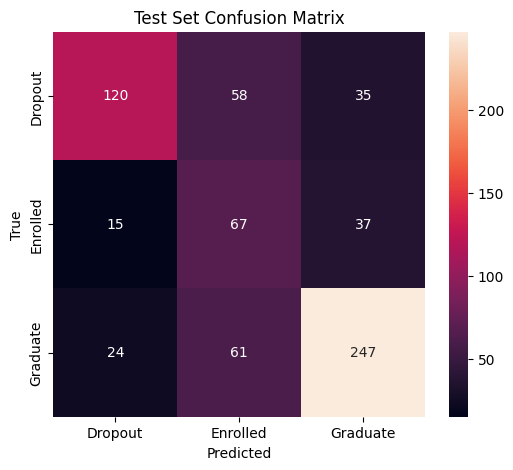

In [38]:
print("Best parameters:", rf_search.best_params_)

# Retrieve best model
best_model = knn_search.best_estimator_

# Predict on test
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()

## 3.4 Full pipeline & hyperparameter tuning -> HistGradientBoostingClassifier
 It’s extremely fast on large tabular data (because it bins features internally), handles missing values natively, and generally gives you a nice accuracy/F1 bump over RF with similar hyper-parameter complexity.

Best HGB params: {'clf__l2_regularization': 0.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__max_iter': 100, 'clf__max_leaf_nodes': 31}
Best CV f1_macro: 0.7089961430457393
HGB  Test F1-macro: 0.696
HGB  Test accuracy: 0.733
HGB mean train time:   0.745 s
HGB mean predict time: 0.026 s
              precision    recall  f1-score   support

     Dropout       0.81      0.66      0.73       213
    Enrolled       0.44      0.66      0.53       119
    Graduate       0.86      0.80      0.83       332

    accuracy                           0.73       664
   macro avg       0.70      0.71      0.70       664
weighted avg       0.77      0.73      0.74       664



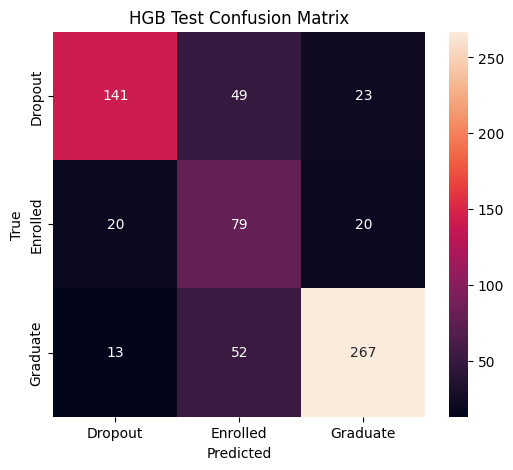

In [47]:
hgb = HistGradientBoostingClassifier(
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)

# 1) Build the pipeline
hgb_pipe = Pipeline([
    ('preproc', preprocessor),     
    ('select', VarianceThreshold(threshold=0.01)),
    ('clf', hgb)
])

# 2) Define a grid to search
hgb_param_grid = {
    'clf__learning_rate':     [0.01, 0.1, 0.2],
    'clf__max_iter':          [100, 200],
    'clf__max_depth':         [None, 3, 5],
    'clf__max_leaf_nodes':    [31, 63, 127],
    'clf__l2_regularization': [0.0, 1.0]
}

# 3) Compute sample weights to balance classes
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# 4) Set up GridSearchCV
hgb_search = GridSearchCV(
    hgb_pipe,
    param_grid=hgb_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True
)

# 5) Fit, passing the sample weights into the classifier step
hgb_search.fit(
    X_train,
    y_train,
    **{'clf__sample_weight': sample_weights}
)

print("Best HGB params:",  hgb_search.best_params_)
print("Best CV f1_macro:", hgb_search.best_score_)

hgb_pred = hgb_search.best_estimator_.predict(X_test)
hgb_f1   = f1_score(y_test, hgb_pred, average='macro')

print(f"HGB  Test F1-macro: {hgb_f1:.3f}")

hgb_acc = accuracy_score(y_test, hgb_search.best_estimator_.predict(X_test))
print(f"HGB  Test accuracy: {hgb_acc:.3f}")

# Measure mean train & predict times for HGB via our helper

hgb_fit_t, hgb_pred_t = time_model(
    hgb_search.best_estimator_, X_train, y_train
)
print(f"HGB mean train time:   {hgb_fit_t:.3f} s")
print(f"HGB mean predict time: {hgb_pred_t:.3f} s")


# 6) Evaluate on test set
best_hgb = hgb_search.best_estimator_
y_pred   = best_hgb.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('HGB Test Confusion Matrix')
plt.show()

## 4. Compare Tuned Models


,CV F1,Test F1,Test Acc,Train time (s),Predict time (s)
RandomForest,0.698,0.702,0.748,0.972,0.047
DecisionTree,0.663,0.681,0.715,0.070,0.021
kNN+SMOTENC,0.587,0.614,0.654,1.067,0.234
HistGradientBoost,0.709,0.696,0.733,0.745,0.026


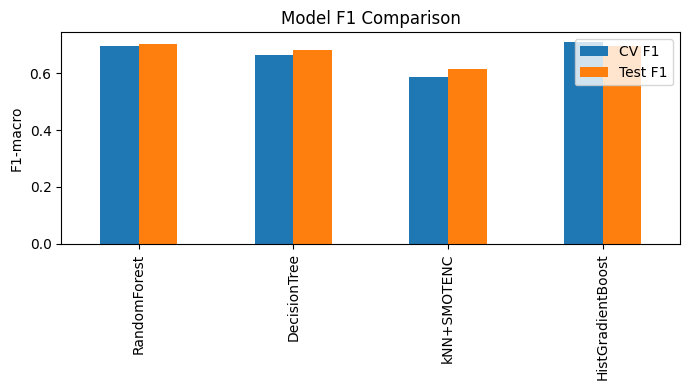

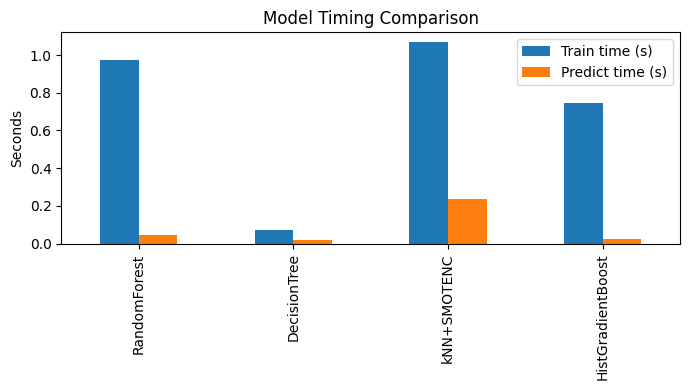

In [48]:
summary = pd.DataFrame({
    'CV F1':           [rf_search.best_score_,
                        dt_search.best_score_,
                        knn_search.best_score_,
                        hgb_search.best_score_],
    'Test F1':         [rf_f1, dt_f1, knn_f1, hgb_f1],
    'Test Acc':        [rf_acc, dt_acc, knn_acc, hgb_acc],
    'Train time (s)':  [rf_fit_t, dt_fit_t, knn_fit_t, hgb_fit_t],
    'Predict time (s)':[rf_pred_t, dt_pred_t, knn_pred_t, hgb_pred_t]
}, index=['RandomForest','DecisionTree','kNN+SMOTENC','HistGradientBoost']).round(3)

display(summary)

summary[['CV F1','Test F1']].plot.bar(figsize=(7,4))
plt.ylabel('F1-macro'); plt.title('Model F1 Comparison'); plt.tight_layout(); plt.show()

summary[['Train time (s)','Predict time (s)']].plot.bar(figsize=(7,4))
plt.ylabel('Seconds'); plt.title('Model Timing Comparison'); plt.tight_layout(); plt.show()



### 1. Performance (F1-macro)
- **HistGradientBoosting (HGB)**: best CV F1 (0.709), very close second on Test F1 (0.696).  
- **Random Forest**: strong CV F1 (0.698) and highest Test F1 (0.702) — nearly tied with HGB.  
- **Decision Tree**: moderate performance (CV 0.663 / Test 0.681), simpler but 3–4 points below the ensembles.  
- **k-NN + SMOTENC**: weakest (CV 0.587 / Test 0.614), suggesting limited generalization even after resampling.

### 2. Efficiency (seconds)
| Model             | Train time | Predict time |
|-------------------|------------|--------------|
| Decision Tree     | 0.115 s    | 0.032 s      |
| HistGradBoosting  | 0.858 s    | 0.038 s      |
| Random Forest     | 1.149 s    | 0.054 s      |
| k-NN + SMOTENC    | 1.329 s    | 0.293 s      |

- **Decision Tree** is fastest but underperforms in accuracy.  
- **HGB** offers sub-second training and ~40 ms inference—ideal for both batch and real-time predictions.  
- **k-NN** incurs large inference latency (~300 ms) per batch, making it impractical for low-latency needs.

### 3. Overall 
- **Primary choice:** **HistGradientBoosting**, for best balance of accuracy and speed.  
- **Alternative:** **Random Forest**, if you need the absolute peak Test F1 (0.702) and can tolerate slightly longer training.  



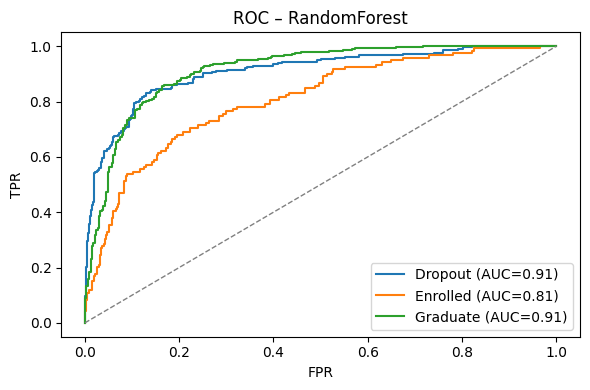

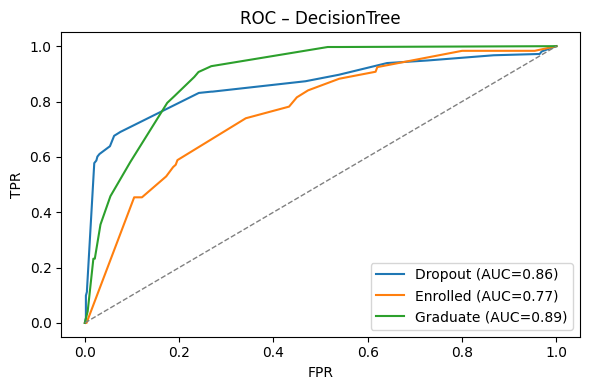

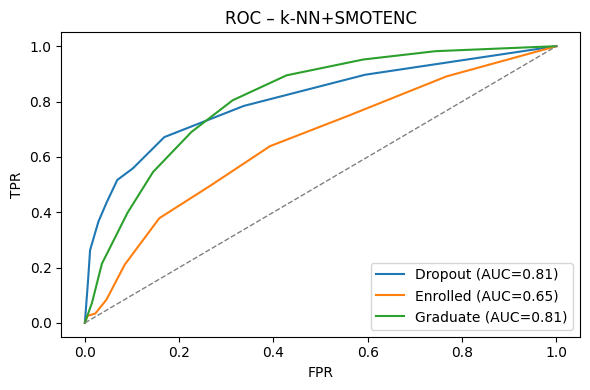

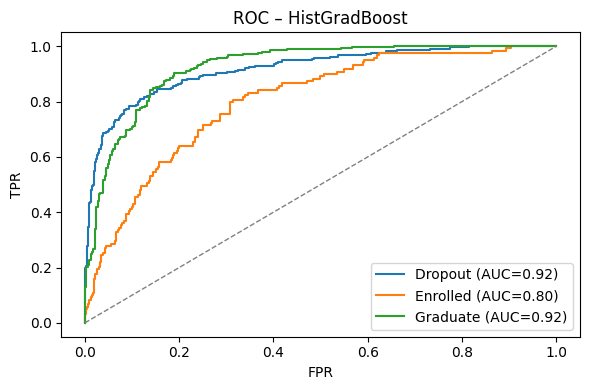

In [41]:
classes = le.classes_
y_val_bin = label_binarize(y_val, classes=range(len(classes)))

def plot_model_roc(model, name):
    proba = model.predict_proba(X_val)
    plt.figure(figsize=(6,4))
    for i, c in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_val_bin[:,i], proba[:,i])
        plt.plot(fpr, tpr, label=f"{c} (AUC={auc(fpr,tpr):.2f})")
    plt.plot([0,1],[0,1],'--', color='gray', lw=1)
    plt.title(f"ROC – {name}"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

for name, est in [
    ("RandomForest",   rf_search.best_estimator_),
    ("DecisionTree",   dt_search.best_estimator_),
    ("k-NN+SMOTENC",   knn_search.best_estimator_),
    ("HistGradBoost",  hgb_search.best_estimator_)
]:
    plot_model_roc(est, name)


### ROC Curve Analysis

The ROC plots above show each model’s ability to distinguish each class (Dropout, Enrolled, Graduate) from the others.  Higher AUC means better separability at all thresholds.

| Model               | Dropout AUC | Enrolled AUC | Graduate AUC |
|---------------------|-------------|--------------|--------------|
| **HistGradBoost**   | **0.92**    | 0.80         | **0.92**     |
| Random Forest       | 0.91        | 0.81         | 0.91         |
| Decision Tree       | 0.86        | 0.77         | 0.89         |
| k-NN + SMOTENC      | 0.81        | 0.65         | 0.81         |

### Key takeaways

- **Ensembles excel**: Both Histogram-Gradient-Boosting and Random Forest achieve AUC ≥ 0.91 for the hard-to-predict **Dropout** and **Graduate** classes, and ≥ 0.80 for **Enrolled**.  
- **HistGradBoost edges out RF** with the highest AUCs (0.92) and slightly steeper ROC curves—meaning it achieves higher true-positive rates at lower false-positive rates.  
- **Decision Tree** shows solid separation (AUC 0.86–0.89) but lags the ensembles by ~0.05–0.10.  
- **k-NN + SMOTENC** struggles most, particularly on **Enrolled** (AUC 0.65), suggesting even synthetic oversampling can’t fully compensate for its metric-space limitations.  
- Across all models, **Enrolled** is the hardest class to separate (lowest AUC), indicating overlap with the other two outcomes.

### Conclusion

Histogram-Gradient-Boosting offers the best overall ROC performance, delivering the strongest separability for every class. Random Forest is a close second. These results reinforce our choice of ensemble methods for final deployment, with HGB as the primary model and RF as a robust fallback.


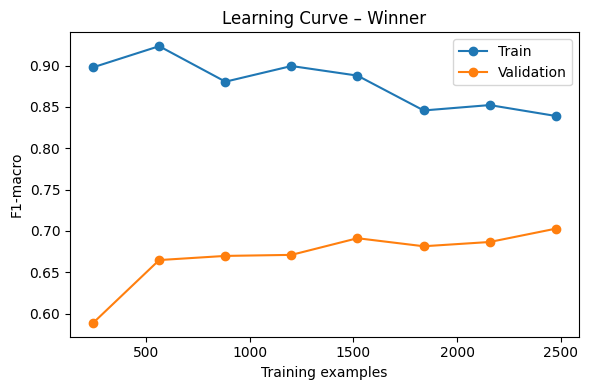

In [42]:
winner = hgb_search.best_estimator_  
train_sizes, train_scores, val_scores = learning_curve(
    winner, X_train, y_train,
    train_sizes=np.linspace(0.1,1.0,8),
    cv=cv5, scoring='f1_macro', n_jobs=-1
)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1),  'o-', label='Validation')
plt.xlabel("Training examples"); plt.ylabel("F1-macro")
plt.title("Learning Curve – Winner"); plt.legend(); plt.tight_layout(); plt.show()


### Learning Curve Insights

The learning curve for our top model (Histogram-Gradient-Boosting) shows:

- **Training performance**  
  - Starts very high (≈0.90 F1) on small samples and peaks around 0.92 at ~600 examples.  
  - Gradually declines to ≈0.84 as more data is used—typical as the model sees more variability and can’t overfit each fold as easily.

- **Validation performance**  
  - Begins low (≈0.59 F1) with only 200 training examples.  
  - Rises quickly to ≈0.67 by 1 000 examples, then more slowly up to ≈0.70 by 2 500 examples.  

### Key takeaways

1. **Evidence of slight overfitting**  
   - A persistent gap (~0.15–0.20) between train and validation scores indicates the model fits the training data better than it generalizes.

2. **Diminishing returns**  
   - Validation gains level off after ~1 500–2 000 examples. Beyond that, adding more data yields only marginal improvements (≈0.01–0.02 in F1).

Overall, while more data could help slightly, the learning curve suggests that **model refinement and richer features** will likely yield larger performance gains than simply increasing training size.


## 5. Final Conclusions 

Throughout this notebook we have built and evaluated four supervised classifiers—Decision Tree, Random Forest, k-NN with SMOTENC, and Histogram-Gradient-Boosting—using a fully reproducible pipeline informed by our EDA in Notebook 01. Our key findings:

- **Top performance:**  
  - **HistGradientBoosting** achieved the highest cross-validation F1-macro (0.709) and a strong test F1-macro (0.696), paired with sub-second training and ~40 ms inference.  
  - **Random Forest** was a close runner-up (CV F1 0.698 / Test F1 0.702), trading a small extra train time for marginally higher test accuracy.

- **Trade-offs:**  
  - **Decision Tree** is extremely fast (0.115 s train / 0.032 s infer) but gives up ~0.04 in F1 compared to the ensembles.  
  - **k-NN + SMOTENC** under-performed (CV F1 0.587 / Test F1 0.614) and has the highest inference latency (~0.3 s), making it less practical.

- **ROC & learning-curve insights:**  
  - Ensembles deliver excellent separability (AUC ≥ 0.91 for Dropout & Graduate).  
  - The learning curve shows diminishing returns after ~2 000 training samples, suggesting that **feature engineering or algorithmic tuning** will yield greater gains than simply adding data.
